# Renda-Classificação

## Introdução

O objetivo desse projeto é prever a renda de um grupo familiar utilizando informações relacionadas a sua residência. Trata-se portanto de um projeto de **regressão supervisionado offline**. 

## Sobre os dados

Os dados utilizados são do **Censo 2000** realizado pelo IBGE e mantido na [Base dos Dados](https://basedosdados.org/dataset/br-ibge-censo-demografico?bdm_table=microdados_domicilio_2000). Informações sobre a metodologia do Censo e sobre a base de dados estão na pasta `materiais`. A extração foi realizada utilizando SQL na platforma do **BigQuery** e a consulta realizada encontra-se na pasta `SQL`. 

Fiz uma amostragem aleatória de 15000 entradas da tabela filtrando os dados faltantes.

## Colunas

Coluna       | Tipo  | Descrição
-------------|-------|-------------------------------
sigla_uf     |str    | Sigla da Unidade da Federação
id_municipio |str    | ID de 7 dígitos do IBGE

In [43]:
# sigla_uf	STRING	Sigla da Unidade da Federação
# id_municipio	STRING	ID Município - IBGE 7 Dígitos
# situacao_domicilio	INT64	Situação do domicílio
# v0110	INT64	Total de homens
# v0111	INT64	Total de mulheres
# v0202	INT64	Tipo do domicílio
# v0203	INT64	Total de cômodos
# v0205	INT64	Condição do domicílio
# v0207	INT64	Forma de abastecimento de água
# v0209	INT64	Total de banheiros
# v0212	INT64	Coleta de lixo
# v0213	INT64	Iluminação elétrica
# v0214	INT64	Existência de rádio
# v0215	INT64	Existência de geladeira ou freezer
# v0216	INT64	Existência de videocassete
# v0217	INT64	Existência de máquina de lavar roupa
# v0218	INT64	Existência de forno de microondas
# v0219	INT64	Existência de linha telefônica instalada
# v0220	INT64	Existência de microcomputador
# v0221	INT64	Quantidade existente de televisores
# v0222	INT64	Quantidade existente de automóveis para uso particular
# v0223	INT64	Quantidade existente de aparelhos de ar condicionado
# v7100	INT64	Total de moradores no domicílio
# v1112	INT64	Existência de iluminação pública
# v1113	INT64	Existência de calçamento/pavimentação

# v7616	INT64	Total de rendimentos do domicílio particular

## Problema de negócio e avaliação do modelo

## Importando e explorando os dados

In [30]:
# Importando bibliotecas

import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [22]:
df = pd.read_csv('data/censo-2000.csv')

In [23]:
df.head()

,sigla_uf,situacao_domicilio,comodos,condicao_domicilio,banheiros,moradores,homens,mulheres,agua,coleta_lixo,...,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,pavimentacao,rendimento
0,SP,1,6.0,1.0,1.0,4,2,2,1.0,1.0,...,2.0,1.0,1.0,2.0,1.0,1.0,0.0,4,2.0,500
1,CE,1,6.0,1.0,1.0,5,4,1,2.0,3.0,...,2.0,2.0,2.0,2.0,1.0,0.0,0.0,5,1.0,260
2,PA,1,6.0,3.0,0.0,10,6,4,2.0,3.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,10,3.0,311
3,SP,1,6.0,5.0,1.0,5,3,2,1.0,1.0,...,2.0,2.0,1.0,2.0,2.0,0.0,0.0,5,1.0,840
4,PR,2,5.0,4.0,1.0,4,3,1,2.0,3.0,...,2.0,2.0,2.0,2.0,1.0,0.0,0.0,4,3.0,170


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sigla_uf            5000 non-null   object 
 1   situacao_domicilio  5000 non-null   int64  
 2   comodos             4967 non-null   float64
 3   condicao_domicilio  4967 non-null   float64
 4   banheiros           4967 non-null   float64
 5   moradores           5000 non-null   int64  
 6   homens              5000 non-null   int64  
 7   mulheres            5000 non-null   int64  
 8   agua                4967 non-null   float64
 9   coleta_lixo         4967 non-null   float64
 10  iluminacao          4967 non-null   float64
 11  radio               4967 non-null   float64
 12  geladeira           4967 non-null   float64
 13  videocassete        4967 non-null   float64
 14  maquina_lavar       4967 non-null   float64
 15  microondas          4967 non-null   float64
 16  telefo

In [25]:
df.describe()

,situacao_domicilio,comodos,condicao_domicilio,banheiros,moradores,homens,mulheres,agua,coleta_lixo,iluminacao,...,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,pavimentacao,rendimento
count,5000.000000,4967.000000,4967.000000,4967.000000,5000.000000,5000.000000,5000.000000,4967.000000,4967.000000,4967.000000,...,4967.000000,4967.00000,4967.000000,4967.000000,4967.000000,4967.000000,4967.000000,5000.000000,4598.000000,5000.000000
mean,1.206600,5.716932,1.782766,1.095832,3.867600,1.904400,1.963200,1.313670,1.769881,1.061808,...,1.692571,1.82726,1.635796,1.907187,1.271391,0.388967,0.107308,3.867600,1.996520,1044.483000
std,0.404906,2.287792,1.300934,0.799011,1.973841,1.272943,1.247139,0.588742,1.383841,0.240831,...,0.461475,0.37806,0.481255,0.290199,0.891876,0.641013,0.455822,1.973841,1.442234,1868.188934
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,10.000000
25%,1.000000,4.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.00000,1.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,268.750000
50%,1.000000,5.000000,1.000000,1.000000,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,...,2.000000,2.00000,2.000000,2.000000,1.000000,0.000000,0.000000,4.000000,1.000000,500.000000
75%,1.000000,7.000000,3.000000,1.000000,5.000000,3.000000,3.000000,1.000000,2.000000,1.000000,...,2.000000,2.00000,2.000000,2.000000,2.000000,1.000000,0.000000,5.000000,3.000000,1050.000000
max,2.000000,20.000000,6.000000,8.000000,18.000000,10.000000,12.000000,3.000000,7.000000,2.000000,...,2.000000,2.00000,2.000000,2.000000,8.000000,7.000000,6.000000,18.000000,9.000000,42500.000000


In [26]:
df.isna().sum()

sigla_uf                0
situacao_domicilio      0
comodos                33
condicao_domicilio     33
banheiros              33
moradores               0
homens                  0
mulheres                0
agua                   33
coleta_lixo            33
iluminacao             33
radio                  33
geladeira              33
videocassete           33
maquina_lavar          33
microondas             33
telefone               33
computador             33
televisores            33
automoveis             33
ar_condicionado        33
iluminacao_publica      0
pavimentacao          402
rendimento              0
dtype: int64

In [27]:
# Train-Test Split

X = df.drop('rendimento', axis=1)
y = df['rendimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## EDA

In [28]:
X_train.head()

,sigla_uf,situacao_domicilio,comodos,condicao_domicilio,banheiros,moradores,homens,mulheres,agua,coleta_lixo,...,videocassete,maquina_lavar,microondas,telefone,computador,televisores,automoveis,ar_condicionado,iluminacao_publica,pavimentacao
4576,RS,1,8.0,1.0,1.0,6,4,2,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,6,3.0
1088,SP,1,4.0,2.0,1.0,5,1,4,1.0,1.0,...,2.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,5,1.0
479,SP,1,5.0,1.0,2.0,4,1,3,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,4,1.0
727,SP,1,4.0,2.0,1.0,3,2,1,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,3,1.0
3783,RS,1,5.0,1.0,1.0,1,0,1,1.0,1.0,...,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1,1.0


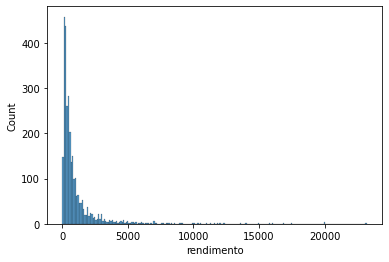

In [34]:
sns.histplot(data=X_train.join(y_train), x='rendimento');

## Modelos de ML

In [64]:
# Tratamento

sim_imp = SimpleImputer(strategy='constant', fill_value=-1)
lab_enc = LabelEncoder()
enc_ct = ColumnTransformer(transformers=[('lab_enc', lab_enc, [0])], remainder='passthrough')

std_scaler = StandardScaler()

tr_pipeline = Pipeline([('imp', sim_imp), ('enc_ct', enc_ct), ('scale', std_scaler)])
tr_pipeline

Pipeline(steps=[('imp', SimpleImputer(fill_value=-1, strategy='constant')),
                ('enc_ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lab_enc', LabelEncoder(),
                                                  [0])])),
                ('scale', StandardScaler())])

In [67]:
tr_pipeline.fit_transform(X_train)

TypeError: fit_transform() takes 2 positional arguments but 3 were given